In [8]:
import os
import glob
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [10]:
IMAGE_DIR = "../data/test_images/"
OUTPUT_DIR = "../outputs/mask_rcnn/"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [11]:
image_paths = []

image_paths.extend(glob.glob(IMAGE_DIR + "*.jpg"))
image_paths.extend(glob.glob(IMAGE_DIR + "*.jpeg"))
image_paths.extend(glob.glob(IMAGE_DIR + "*.png"))

image_paths = sorted(image_paths)

print(f"Found {len(image_paths)} images")


Found 23 images


In [12]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights="DEFAULT"
)

model.to(device)
model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])


Processed: hardik1.jpeg
Processed: hardik1h.jpeg
Processed: hardik2.jpeg
Processed: hardik2h.jpeg
Processed: hardik3.jpeg
Processed: hardik3h.jpeg
Processed: rohit1.jpeg
Processed: rohit2.jpeg
Processed: rohit2h.jpeg
Processed: rohit3.jpeg
Processed: rohit3h.jpeg
Processed: shreyas1.jpeg
Processed: shreyas1h.jpeg
Processed: shreyas2.jpeg
Processed: shreyas2h.jpeg
Processed: shreyas3.jpeg
Processed: shreyas3h.jpeg
Processed: virat1.jpeg
Processed: virat1h.jpeg
Processed: virat2.jpeg


/tmp/ipykernel_50163/797583861.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 6))


Processed: virat2h.jpeg
Processed: virat3.jpeg
Processed: virat3h.jpeg


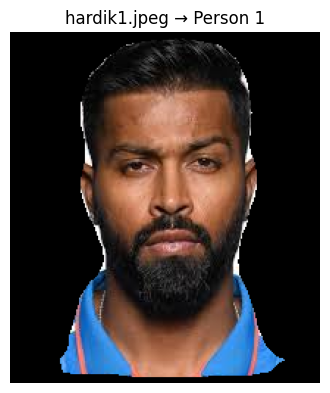

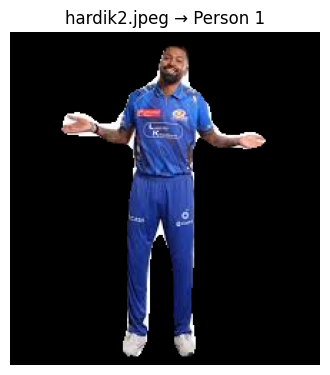

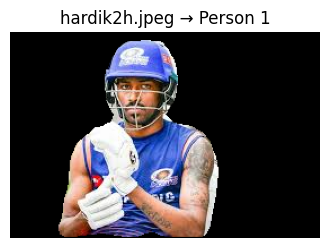

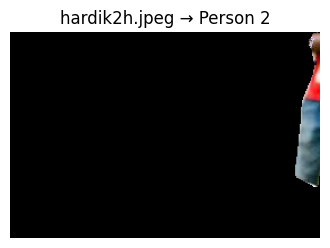

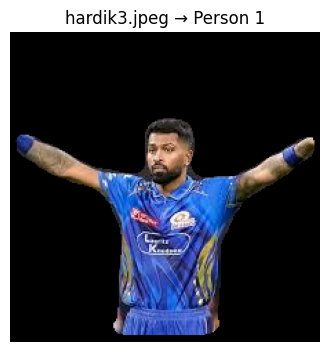

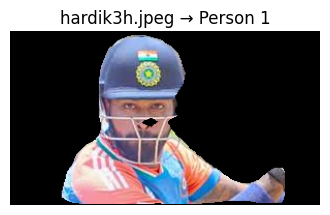

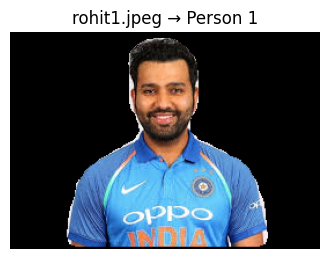

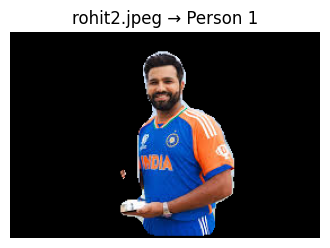

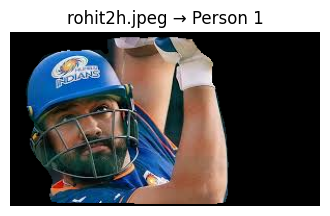

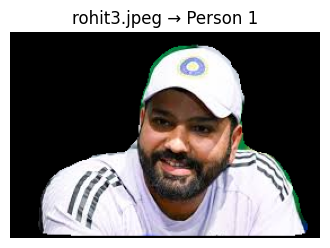

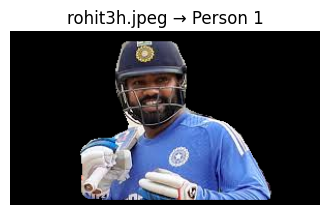

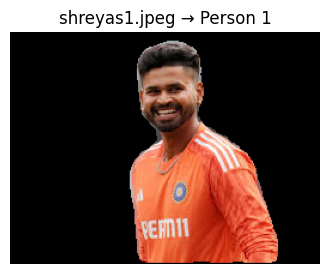

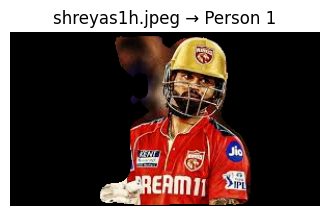

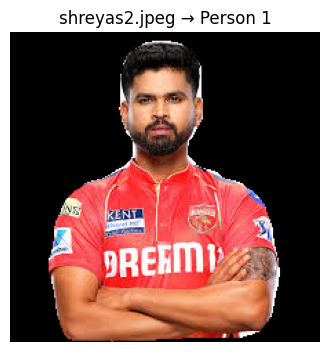

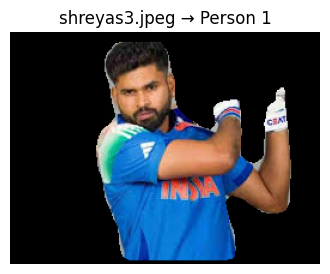

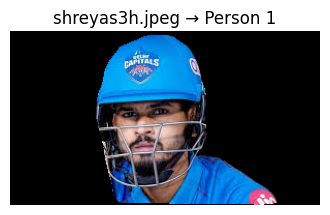

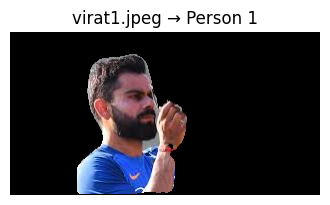

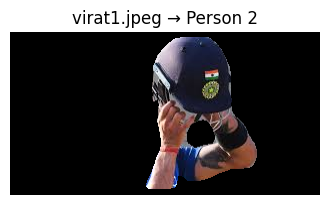

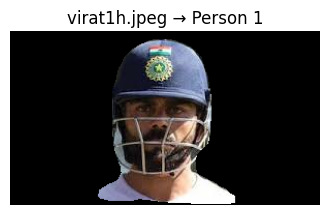

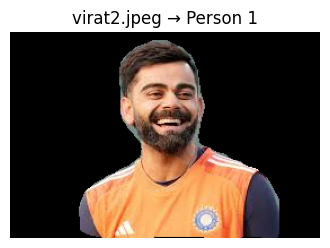

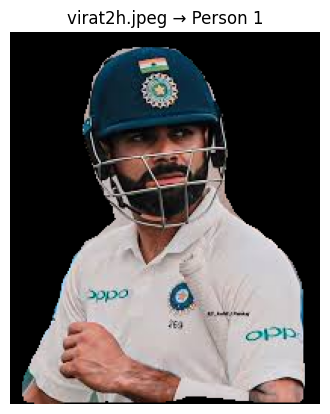

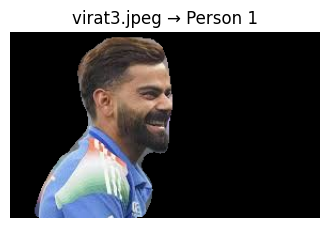

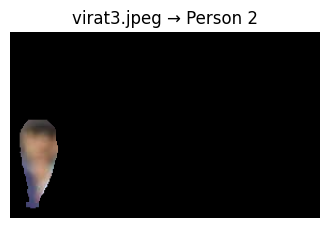

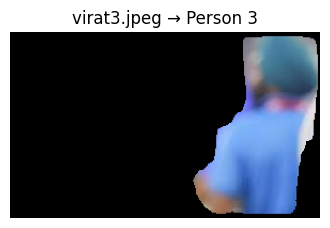

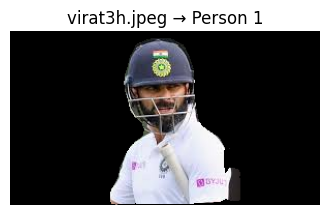

In [14]:
CONF_THRESHOLD = 0.8
MASK_THRESHOLD = 0.5

for img_path in image_paths:
    img = cv2.imread(img_path)
    img_name = os.path.basename(img_path)

    if img is None:
        continue

    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor_img = transform(rgb).to(device)

    with torch.no_grad():
        outputs = model([tensor_img])[0]

    boxes = outputs["boxes"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()
    masks = outputs["masks"].cpu().numpy()

    person_count = 0

    for i in range(len(scores)):
        if scores[i] < CONF_THRESHOLD:
            continue

        if labels[i] == 1: 
            person_count += 1

            mask = masks[i, 0]
            mask = (mask > MASK_THRESHOLD).astype(np.uint8)

            segmented = img.copy()
            segmented[mask == 0] = 0

            save_name = img_name.replace(
                ".", f"_person{person_count}."
            )

            save_path = os.path.join(OUTPUT_DIR, save_name)
            cv2.imwrite(save_path, segmented)

           
            plt.figure(figsize=(4, 6))
            plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
            plt.title(f"{img_name} → Person {person_count}")
            plt.axis("off")

    print(f"Processed: {img_name}")
